# Analog circuit for preparing a GHZ state

GHZ states, much like Bell states, are highly entangled, multi-qubit states. They have broad application in quantum error correction, quantum communication protocols, quantum sensing, and tests of fundamental physics. Here, we will construct and emulate the analog quantum program to prepare a `n`-qubit GHZ state,
$$
|\psi\rangle = \frac{1}{\sqrt{2}} \left( |0\rangle^{\otimes n} + |1\rangle^{\otimes n} \right)
$$

First, we import the relevant libraries and OQD modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import itertools
import operator

import warnings
warnings.filterwarnings("ignore")

from oqd_core.interface.analog.operator import *
from oqd_core.interface.analog.operation import *
from oqd_core.backend.metric import *
from oqd_core.backend.task import Task, TaskArgsAnalog

from oqd_analog_emulator.qutip_backend import QutipBackend

In [2]:
X = PauliX()
Y = PauliY()
Z = PauliZ()
I = PauliI()

n = 3

In [3]:
def sum(args):
    return functools.reduce(operator.add, args)


def prod(args):
    return functools.reduce(operator.mul, args)


def tensor(args):
    return functools.reduce(operator.matmul, args)

In [4]:
# Hadamard on first qubit
ii = tensor([I for i in range(n)])
xi = tensor([X if i == 0 else I for i in range(n)])
yi = tensor([Y if i == 0 else I for i in range(n)])

circuit = AnalogCircuit()

# evolve Hadamard gate
circuit.evolve(duration=(3 * np.pi) / 2, gate=AnalogGate(hamiltonian=ii))
circuit.evolve(duration=np.pi / 2, gate=AnalogGate(hamiltonian=xi))
circuit.evolve(duration=np.pi / 4, gate=AnalogGate(hamiltonian=-1 * yi))

for j in range(1, n):
    xx = tensor([X if i in (0, j) else I for i in range(n)])
    mix = -1 * tensor([X if i == j else I for i in range(n)])

    # CNOT
    circuit.evolve(duration=np.pi / 4, gate=AnalogGate(hamiltonian=yi))
    circuit.evolve(duration=np.pi / 4, gate=AnalogGate(hamiltonian=xx))
    circuit.evolve(duration=np.pi / 4, gate=AnalogGate(hamiltonian=mix))
    circuit.evolve(duration=np.pi / 4, gate=AnalogGate(hamiltonian=-xi))
    circuit.evolve(duration=np.pi / 4, gate=AnalogGate(hamiltonian=-yi))
    circuit.evolve(duration=np.pi / 4, gate=AnalogGate(hamiltonian=ii))
    
circuit.measure()

In [5]:
# define task args
args = TaskArgsAnalog(
    n_shots=1000,
    fock_cutoff=4,
    metrics={
        f"Z_{i}": Expectation(operator=tensor([Z if j == i else I for j in range(n)]))
        for i in range(n)
    },
    dt=1e-2,
)
task = Task(program=circuit, args=args)

In [6]:
backend = QutipBackend()
results = backend.run(task=task)

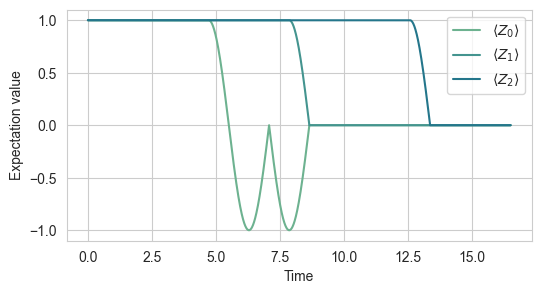

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])
colors = sns.color_palette(palette="crest", n_colors=max([4, n]))

for k, (name, metric) in enumerate(results.metrics.items()):
    ax.plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])
ax.legend()
ax.set(xlabel="Time", ylabel="Expectation value");

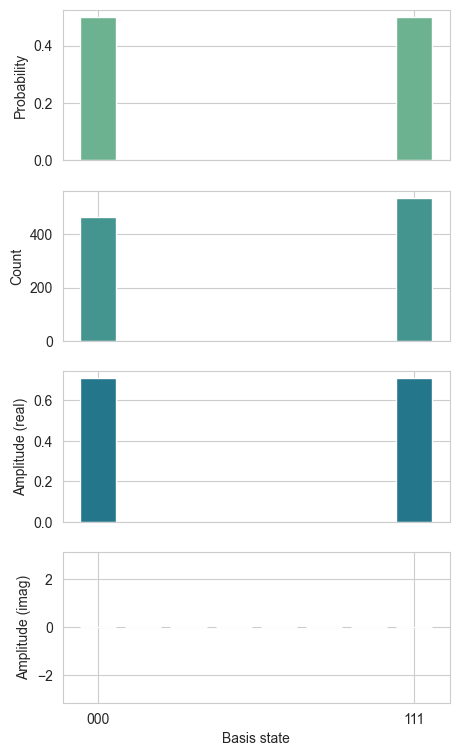

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[5, 9])

state = np.array([basis.real + 1j * basis.imag for basis in results.state])
bases = ["".join(bits) for bits in itertools.product("01", repeat=n)]
counts = {basis: results.counts.get(basis, 0) for basis in bases}

ax = axs[0]
ax.bar(x=bases, height=np.abs(state) ** 2, color=colors[0])
ax.set(ylabel="Probability")


ax = axs[1]
ax.bar(x=bases, height=list(counts.values()), color=colors[1])
ax.set(ylabel="Count")


ax = axs[2]
ax.bar(x=bases, height=state.real, color=colors[2])
ax.set(ylabel="Amplitude (real)")

ax = axs[3]
ax.bar(x=bases, height=state.imag, color=colors[3])
ax.set_xticks([bases[0], bases[-1]])
ax.set(xlabel="Basis state", ylabel="Amplitude (imag)", ylim=[-np.pi, np.pi]);